<a href="https://colab.research.google.com/github/masc-it/ML/blob/master/TPU/Object%20Detection/tpu_od.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TPU ready Custom Object Detection

# Installation

Installing the Tensorflow Object Detection API became a lot easier with the relase of Tensorflow 2. The following few cells are all that is needed in order to install the OD API.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Coral

Remeber to reboot runtime then (if asked)!

In [ ]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 39kB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 512kB 51.3MB/s 
     |████████████████████████████████| 3.8MB 46.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=719a3173911c16e26f9e3aa6e8250e49f044fcccc77650205ccff9af50ab5e44
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninsta

In [ ]:
import tensorflow as tf

print(tf.__version__)

1.15.0


In [ ]:
!rm -rf models
import os
import pathlib
!rm -rf models
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2476, done.
remote: Counting objects: 100% (2476/2476), done.
remote: Compressing objects: 100% (2061/2061), done.
remote: Total 2476 (delta 612), reused 1145 (delta 386), pack-reused 0
Receiving objects: 100% (2476/2476), 30.87 MiB | 36.00 MiB/s, done.
Resolving deltas: 100% (612/612), done.


### Install od deps

Remember to change tf1 or tf2

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf1/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1630656 sha256=de242f484b632d38426ddb57495fdb7f075bcc29d47b787b4bb789c9e5aed22b
  Stored in directory: /tmp/pip-ephem-wheel-cache-nqxq1uoe/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


In [ ]:
#run model builder test (if you want)
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

### Mount drive and set env variables

In [ ]:
base_path = "/content/drive/MyDrive/dataset/people"
dataset_path = base_path + "/dataset"

tfrecord_generator_script = base_path + "/generate_tfrecord.py"

train_labels_csv = dataset_path + "/train_labels.csv"
test_labels_csv = dataset_path + "/test_labels.csv"

model_path = base_path + "/model"
export_path = model_path + "/export"
config_file = base_path + "/pipeline.config"
checkpoint_dir = model_path 


train_path = dataset_path + "/train"
test_path = dataset_path + "/test"

train_record_path = dataset_path + '/train.tfrecord'
test_record_path = dataset_path + '/test.tfrecord'

labelmap_path = dataset_path + '/labelmap.pbtxt'


od_models_base = "/content/drive/My Drive/od_models"

od_model_path = od_models_base + "/ssdlite_mobiledet"
fine_tune_checkpoint = od_model_path + '/model.ckpt'
orig_config = od_model_path + '/pipeline.config'
!cp "$orig_config" "$base_path/pipeline.config"

# Configuring training

Now that the data is ready it's time to create a training configuration. The OD API supports lots of models, each with its own config file. In this notebook I'm making use of EfficientDet, but you can replace it with any model available in the [Tensorflow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).

In [ ]:
batch_size = 16
num_steps = 50000
num_eval_steps = 200

### Tweak pipeline

```
model_main.py line 62
config = tf.estimator.RunConfig(model_dir=FLAGS.model_dir, save_checkpoints_steps=1000, keep_checkpoint_max=20)

config

data_augmentation_options {
    ssd_random_crop {
    }
    random_vertical_flip {}
    random_horizontal_flip {}
    random_rotation90 {}
    random_adjust_saturation {}
    random_adjust_contrast {} 
  }

```



In [ ]:
# edit configuration file with custom params

import re

with open(orig_config) as f:
    config = f.read()

with open(config_file, 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), config) # 
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED.*?train.*?)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED.*?val.*?)(.*?")', # DATASET_DIR_TO_CONFIGURE
                  'input_path: "{}"'.format(test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(1), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(batch_size), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(num_steps), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  #config = re.sub('height: 320', 
  #           'height: {}'.format(300), config)
  
  #config = re.sub('width: 320', 
  #           'width: {}'.format(300), config)
  
  f.write(config)

In [ ]:
!cat "$config_file"

# SSDLite with MobileDet-EdgeTPU feature extractor.
# Reference: Xiong & Liu et al., https://arxiv.org/abs/2004.14525
# Trained on COCO, initialized from scratch.
#
# 1.53B MulAdds, 4.20M Parameters. Latency is 6.9ms on Pixel 4 EdgeTPU.
# Achieves 25.6 mAP on COCO14 minival dataset with quantization-aware training.
#
# This config is TPU compatible.

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
     

# Train detector

In [ ]:
!cat /content/models/research/object_detection/model_main.py

# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Binary to run train and evaluation on object detection model."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import flags

import tensorflow.compat.v1 as tf

from object_detection import model_lib

flags.DEFINE_string(
    'model_d

In [ ]:
#import tensorflow as tf
import sys
#sys.path.append("/content/models/research/slim/")
!python /content/models/research/object_detection/model_main.py \
  --pipeline_config_path="{config_file}" \
  --model_dir="{model_path}" \
  --num_train_steps={num_steps}

W0327 10:34:14.627275 140255065155456 model_lib.py:813] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 50000
I0327 10:34:14.631256 140255065155456 config_util.py:552] Maybe overwriting train_steps: 50000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0327 10:34:14.631399 140255065155456 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0327 10:34:14.631486 140255065155456 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0327 10:34:14.631577 140255065155456 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0327 10:34:14.631691 140255065155456 model_lib.py:829] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

## Export model

In [ ]:
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
  --pipeline_config_path="{config_file}" \
  --trained_checkpoint_prefix="{checkpoint_dir}/model.ckpt-1332" \
  --output_directory="{export_path}/ssd" \
  --add_postprocessing_op=true

Instructions for updating:
Please use `layer.__call__` method instead.
W0326 10:11:50.673137 140537479186304 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0326 10:11:53.645810 140537479186304 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0326 10:11:53.747672 140537479186304 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0326 10:11:53.850694 140537479186304 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [ ]:
!tflite_convert \
  --output_file="{export_path}/output_tflite_graph.tflite" \
  --graph_def_file="{export_path}/ssd/tflite_graph.pb" \
  --inference_type=QUANTIZED_UINT8 \
  --input_arrays="normalized_input_image_tensor" \
  --output_arrays="TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3" \
  --mean_values=128 \
  --std_dev_values=128 \
  --input_shapes=1,300,300,3 \
  --change_concat_input_ranges=false \
  --allow_nudging_weights_to_use_fast_gemm_kernel=true \
  --allow_custom_ops

2021-03-26 10:12:28.912967: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-03-26 10:12:28.935513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-26 10:12:28.936278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
2021-03-26 10:12:28.936588: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-03-26 10:12:28.937955: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-03-26 10:12:28.939145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.

## TPU compile

In [ ]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1974  100  1974    0     0  22953      0 --:--:-- --:--:-- --:--:-- 22953
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [49.8 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://deve

In [ ]:
!edgetpu_compiler -h

Edge TPU Compiler version 15.0.340273435

Usage:
edgetpu_compiler [options] model...

Options:
-o, --out_dir <dir>
       Output the compiled model and log files to directory <dir>.
       Default is the current directory (.)
-m, --min_runtime_version <val>
       Minimum Edge TPU runtime version required by your model.
       Models are forward-compatible with new Edge TPU runtimes.
       Default: 12; Min: 10; Max: 13
-i, --intermediate_tensors <str>
        A comma-separated list of tensors you want as outputs from
        the Edge TPU custom op. All operators following these tensors
       will not be compiled for the Edge TPU but are still in the
       .tflite file and will run on the CPU. If you have multiple
       input models (for co-compilation), then separate the list of
       tensors for each model with a colon, and pass them in the
       order corresponding to the input models.
-n, --num_segments <val>
       Partition the model into [num_segments] segments.
       Defa

In [ ]:
! edgetpu_compiler -s -a "/content/drive/MyDrive/dataset/mauro/model/export/output_tflite_graph.tflite"

Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 1211 ms.

Input model: /content/drive/MyDrive/dataset/mauro/model/export/output_tflite_graph.tflite
Input size: 3.27MiB
Output model: output_tflite_graph_edgetpu.tflite
Output size: 4.36MiB
On-chip memory used for caching model parameters: 4.11MiB
On-chip memory remaining for caching model parameters: 3.52MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 125
Operation log: output_tflite_graph_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 124
Number of operations that will run on CPU: 1

Operator                       Count      Status



# Test tf lite

In [ ]:
from PIL import Image
import numpy as np

interpreter = tf.lite.Interpreter(model_path=export_path + "/output_tflite_graph.tflite")
interpreter.allocate_tensors()
# obtaining the input-output shapes and types
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_img = Image.open("/content/drive/MyDrive/dataset/microcontroll_od/dataset/train/20201129153510.jpg")
# resizing input_img
input_img = input_img.resize((300,300))
# seperating the input image into constituent channels
input_img = np.array(input_img, dtype=np.uint8)
x = np.expand_dims(input_img, axis=0)
print(input_details[0]['shape'])


# RUNNING INTERPRETER
# setting the input tensor with the selected input
interpreter.set_tensor(input_details[0]['index'], x)

# running inference
interpreter.invoke()

y_matrix = interpreter.get_tensor(output_details[0]['index'])
print(y_matrix)

[  1 300 300   3]
[[[ 0.47817877  0.34846523  0.7651727   0.955053  ]
  [ 0.5388305   0.3257829   0.9582795   0.7712374 ]
  [ 0.3410886   0.47585958  0.7559317   0.8276586 ]
  [ 0.3144611   0.10196027  0.7969264   0.93101645]
  [ 0.2907512  -0.02616742  0.7371793   0.65400815]
  [ 0.41667312  0.24521628  0.65628046  0.851804  ]
  [ 0.41852668  0.08461916  0.66374296  0.61231136]
  [ 0.51321214  0.42903185  0.9586666   0.8744863 ]
  [ 0.4330598   0.4847089   0.66396046  1.0124011 ]
  [ 0.46580717  0.28173462  0.837711    0.8152857 ]]]


# Test trained model on test images

In [ ]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [ ]:
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/content/{output_directory}/saved_model')

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

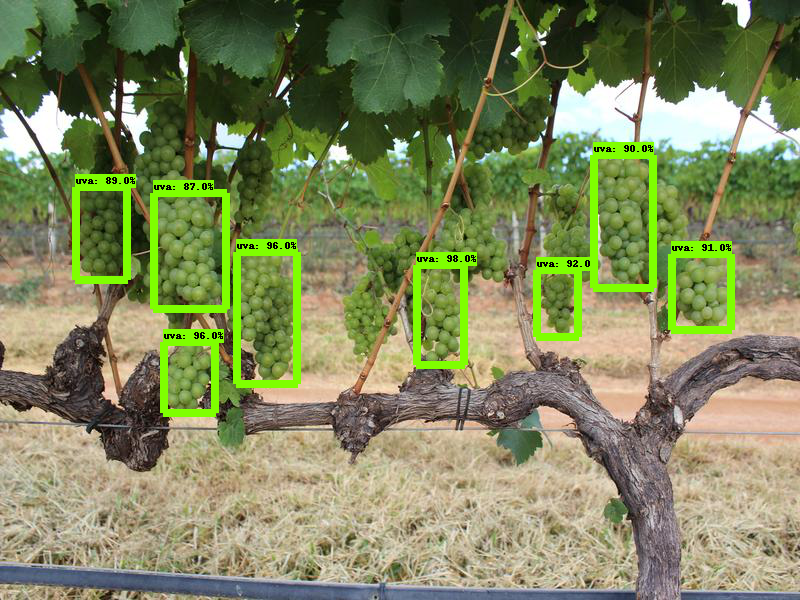

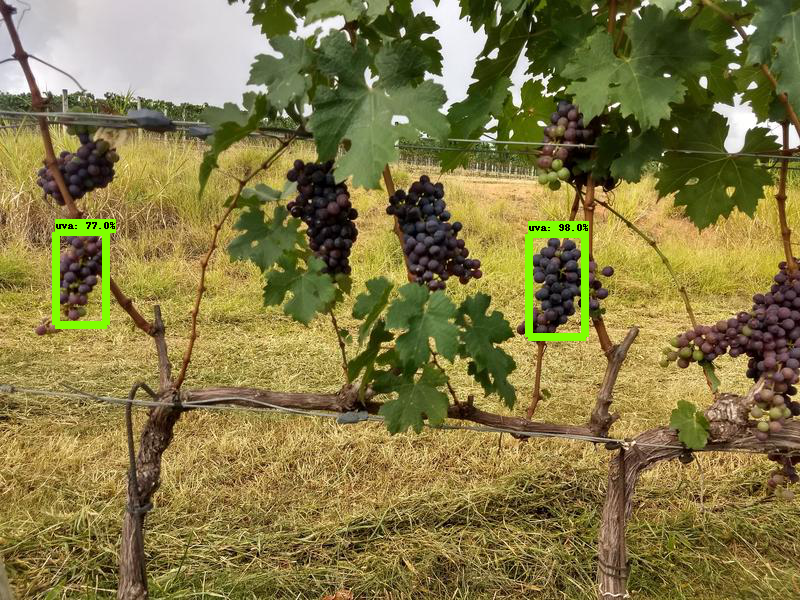

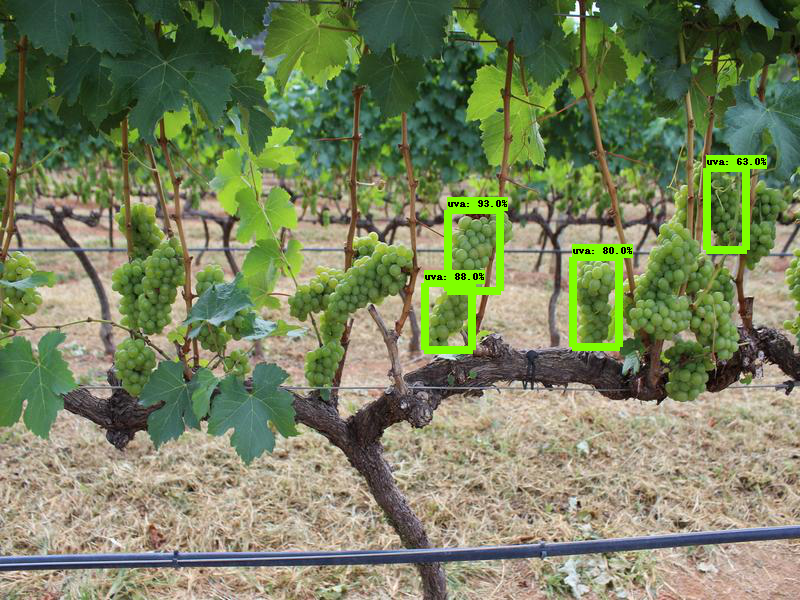

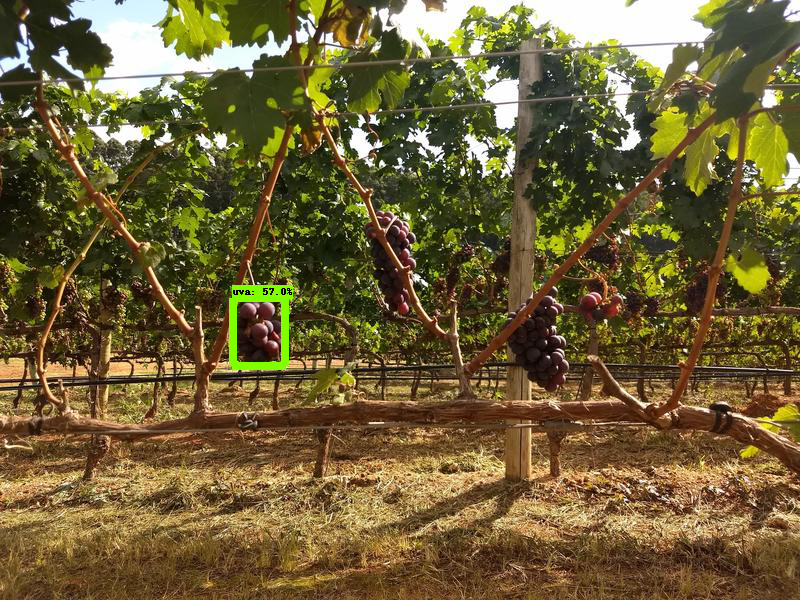

In [ ]:
for image_path in glob.glob('uva/test/*.jpg'):
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  display(Image.fromarray(image_np))